In [1]:
import os
import torch
import torchvision

import torchvision.transforms as transforms
import numpy as np
import matplotlib.pylab as plt

from utils import FullyConnectedNN, compute_confusion_matrix, train, evaluate

# Define hyperparameters etc.

In [2]:
datadir = '../datasets'
batch_size = 32
learning_rate = 0.001
num_epochs = 1
indim = 784
outdim = 10
hdim = 100
num_hidden = 2
print_every = 100

# Dataset

In [3]:
# define transform to map data from a PIL.Image data type
# to a Tensor which is what pytorch uses
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

# (down)load training and testing datasets
emnist_traindata = torchvision.datasets.EMNIST(datadir, split='mnist', download=True, transform=transform)
emnist_testdata = torchvision.datasets.EMNIST(datadir, split='mnist', train=False, download=True, transform=transform)

train_num_examples, _, _ = emnist_traindata.data.shape
test_num_examples, _, _ = emnist_testdata.data.shape

print('Training dataset has {train_num_examples}, test dataset has {test_num_examples}'.format(train_num_examples=train_num_examples, test_num_examples=test_num_examples))

Training dataset has 60000, test dataset has 10000


# Fully-connected neural network

In [4]:
fcnet = FullyConnectedNN(indim, outdim, hdim, num_hidden)

In [5]:
params = fcnet.parameters()
num_params = np.sum([np.prod(p.shape) for p in params])
print('The number of parameters in the network is: {}'.format(num_params))

The number of parameters in the network is: 89610


In [6]:
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnet.parameters(), lr=learning_rate)

In [7]:
# create dataloader
trainloader = torch.utils.data.DataLoader(emnist_traindata, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(emnist_testdata, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
# make weights trainable
fcnet.train()

# run training loop
training_loss = train(num_epochs, print_every, trainloader, loss_fcn, optimizer, fcnet)

Epoch: 0, Iteration: 0, Loss: 2.34, Acc: 0.06
Epoch: 0, Iteration: 100, Loss: 0.47, Acc: 0.91
Epoch: 0, Iteration: 200, Loss: 0.16, Acc: 0.97
Epoch: 0, Iteration: 300, Loss: 0.46, Acc: 0.88
Epoch: 0, Iteration: 400, Loss: 0.28, Acc: 0.91
Epoch: 0, Iteration: 500, Loss: 0.09, Acc: 0.97
Epoch: 0, Iteration: 600, Loss: 0.51, Acc: 0.88
Epoch: 0, Iteration: 700, Loss: 0.28, Acc: 0.88
Epoch: 0, Iteration: 800, Loss: 0.47, Acc: 0.91
Epoch: 0, Iteration: 900, Loss: 0.31, Acc: 0.94
Epoch: 0, Iteration: 1000, Loss: 0.17, Acc: 0.94
Epoch: 0, Iteration: 1100, Loss: 0.15, Acc: 0.94
Epoch: 0, Iteration: 1200, Loss: 0.30, Acc: 0.97
Epoch: 0, Iteration: 1300, Loss: 0.20, Acc: 0.94
Epoch: 0, Iteration: 1400, Loss: 0.11, Acc: 0.97
Epoch: 0, Iteration: 1500, Loss: 0.16, Acc: 0.91
Epoch: 0, Iteration: 1600, Loss: 0.12, Acc: 0.97
Epoch: 0, Iteration: 1700, Loss: 0.13, Acc: 0.94
Epoch: 0, Iteration: 1800, Loss: 0.16, Acc: 0.97


Text(0, 0.5, 'Cross Entropy Loss')

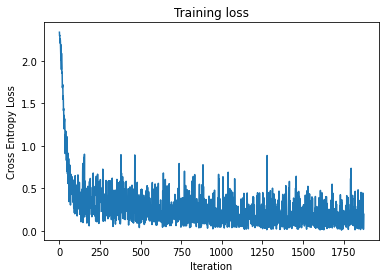

In [9]:
# plot training loss
plt.plot(training_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')

In [10]:
# make weights not trainable
fcnet.eval()

average_accuracy, average_loss, prediction_label_data = evaluate(testloader, loss_fcn, fcnet)
    
print('Avg Loss: {loss:.2f}, Avg Acc: {acc:.2f}'.format(loss=average_loss, acc=average_accuracy))

Avg Loss: 0.15, Avg Acc: 0.95


Text(0.5, 1.0, 'Label: 9, Prediction 7')

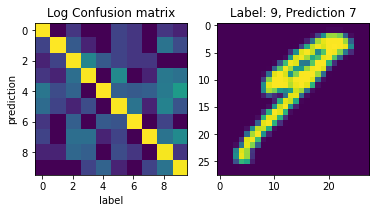

In [11]:
confusion_matrix, mistakes = compute_confusion_matrix(prediction_label_data)
# get image with wrong prediction
mistake_idx = np.random.randint(len(mistakes))
mistake_pred, mistake_label, mistake_data = mistakes[mistake_idx]
mistake_img = mistake_data.squeeze().T

plt.subplot(121)
plt.imshow(np.log(confusion_matrix))
plt.title('Log Confusion matrix')
plt.xlabel('label')
plt.ylabel('prediction')

plt.subplot(122)
plt.imshow(mistake_img)
plt.title('Label: {label}, Prediction {pred}'.format(label=mistake_label, pred=mistake_pred))

# Convolutional neural network

In [12]:
class ConvolutionalNN(torch.nn.Module):
    '''
    
    https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
    '''
    def __init__(self, filter_shapes, outdim):
        '''
        filter_shapes : list of tuples
            each tuple provides a filter shape (in channels, out channels, filter height)
        '''
        super(ConvolutionalNN, self).__init__()
        
        self.filter_shapes = filter_shapes
        self.num_layers = len(filter_shapes)
        
        layers = []
        for i in range(self.num_layers):
            conv_layer = torch.nn.Conv2d(*self.filter_shapes[i])
            nonlinearity = torch.nn.ReLU()
            layers.extend([conv_layer, nonlinearity])
            
        layers.append(torch.nn.Flatten())
        # implement a function to compute this number!!!
        # https://cs231n.github.io/convolutional-networks/#conv
        # https://stackoverflow.com/questions/34739151/calculate-dimension-of-feature-maps-in-convolutional-neural-network
        num_final_feature_params = 512
        hidden2out = torch.nn.Linear(num_final_feature_params, outdim)
        # print(hidden2out)
        layers.append(hidden2out)
        
        self.model = torch.nn.Sequential(*layers)
        # print(self.model)
    
    def forward(self, data):
        return self.model.forward(data)

# Define hyperparameters etc.

In [13]:
batch_size = 32
learning_rate = 0.001
num_epochs = 1
filter_shapes = [(1, 8, 5), (8, 16, 5), (16, 64, 5), (64, 16, 5), (16, 8, 5)]
outdim = 10
print_every = 100

In [14]:
convnet = ConvolutionalNN(filter_shapes, outdim)

In [15]:
params = convnet.parameters()
num_params = np.sum([np.prod(p.shape) for p in params])
print('The number of parameters in the network is: {}'.format(num_params))

The number of parameters in the network is: 63042


In [16]:
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=learning_rate)

In [17]:
# create dataloader
trainloader = torch.utils.data.DataLoader(emnist_traindata, batch_size=batch_size, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(emnist_testdata, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
# make weights trainable
convnet.train()

# run training loop
training_loss = train(num_epochs, print_every, trainloader, loss_fcn, optimizer, convnet)

Epoch: 0, Iteration: 0, Loss: 2.30, Acc: 0.09
Epoch: 0, Iteration: 100, Loss: 0.50, Acc: 0.84
Epoch: 0, Iteration: 200, Loss: 0.28, Acc: 0.88
Epoch: 0, Iteration: 300, Loss: 0.11, Acc: 0.94
Epoch: 0, Iteration: 400, Loss: 0.06, Acc: 1.00
Epoch: 0, Iteration: 500, Loss: 0.10, Acc: 0.97
Epoch: 0, Iteration: 600, Loss: 0.16, Acc: 0.97
Epoch: 0, Iteration: 700, Loss: 0.03, Acc: 1.00
Epoch: 0, Iteration: 800, Loss: 0.21, Acc: 0.91
Epoch: 0, Iteration: 900, Loss: 0.24, Acc: 0.97
Epoch: 0, Iteration: 1000, Loss: 0.01, Acc: 1.00
Epoch: 0, Iteration: 1100, Loss: 0.03, Acc: 1.00
Epoch: 0, Iteration: 1200, Loss: 0.19, Acc: 0.91
Epoch: 0, Iteration: 1300, Loss: 0.01, Acc: 1.00
Epoch: 0, Iteration: 1400, Loss: 0.16, Acc: 0.94
Epoch: 0, Iteration: 1500, Loss: 0.05, Acc: 0.97
Epoch: 0, Iteration: 1600, Loss: 0.06, Acc: 0.97
Epoch: 0, Iteration: 1700, Loss: 0.07, Acc: 1.00
Epoch: 0, Iteration: 1800, Loss: 0.12, Acc: 0.97


Text(0, 0.5, 'Cross Entropy Loss')

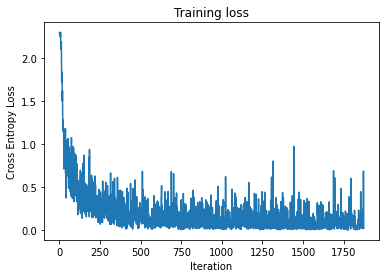

In [19]:
# plot training loss
plt.plot(training_loss)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')

In [20]:
convnet.eval()

average_accuracy, average_loss, prediction_label_data = evaluate(testloader, loss_fcn, convnet)
    
print('Avg Loss: {loss:.2f}, Avg Acc: {acc:.2f}'.format(loss=average_loss, acc=average_accuracy))

Avg Loss: 0.09, Avg Acc: 0.97


Text(0.5, 1.0, 'Label: 3, Prediction 2')

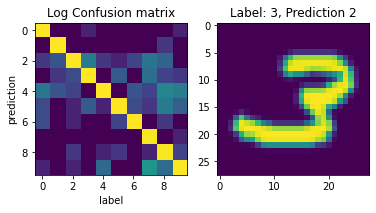

In [21]:
confusion_matrix, mistakes = compute_confusion_matrix(prediction_label_data)
# get image with wrong prediction
mistake_idx = np.random.randint(len(mistakes))
mistake_pred, mistake_label, mistake_data = mistakes[mistake_idx]
mistake_img = mistake_data.squeeze().T

plt.subplot(121)
plt.imshow(np.log(confusion_matrix))
plt.title('Log Confusion matrix')
plt.xlabel('label')
plt.ylabel('prediction')

plt.subplot(122)
plt.imshow(mistake_img)
plt.title('Label: {label}, Prediction {pred}'.format(label=mistake_label, pred=mistake_pred))